## Importamos las bibliotecas a usar

In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
import geopandas
import fiona
import rtree
from shapely.geometry import Point
import folium
import matplotlib
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot

np.set_printoptions(suppress=True)
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 250
matplotlib.rcParams['figure.figsize'] = (8, 8)

#### LLamada al archivo

In [2]:
df = pd.read_csv('properatti.csv')
df_original = df.copy()
df.shape

(121220, 26)

In [3]:
df.sample()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
12950,12950,sell,apartment,Boca,|Argentina|Capital Federal|Boca|,Argentina,Capital Federal,3436004.0,"-34.633862,-58.361615",-34.633862,...,35.0,1800.0,1800.0,NaN,2.0,NaN,http://www.properati.com.ar/16noc_venta_departamento_boca_luminoso_de-nichilo-propiedades,"Departamento a una cuadra de la Av. Almirante Brown donde se ubican numerosas paradas de colectivos que conectan principalmente con la ciudad de Bs. As. y el Sur de la Provincia, cerca de la Usina del Arte, de Caminito luminoso.",Departamento 2 Ambientes,https://thumbs4.properati.com/7/cwSTs5vOzbrxaO2mkQM4kTMY6ZE=/trim/198x0/smart/filters:strip_icc()/services.neoinmuebles.com/i/DNCH/feed/1391.jpg


## 1. Revisar valores nulos por columna

In [4]:
(df.isna().sum()/len(df)).sort_values(ascending=False) #porcentaje de blancos con respecto al total

floor                      0.934837
expenses                   0.882346
rooms                      0.609058
price_usd_per_m2           0.433947
lon                        0.425260
                             ...   
country_name               0.000000
place_with_parent_names    0.000000
property_type              0.000000
operation                  0.000000
Unnamed: 0                 0.000000
Length: 26, dtype: float64

- Se descartan las columnas Floor y expenses por falta de datos

## 2. Revisar valores unicos por columna

1.   Elemento de lista
2.   Elemento de lista



In [5]:
df.nunique().sort_values()

operation               1
country_name            1
currency                4
property_type           4
state_name             28
                    ...  
title               72705
description        104055
image_thumbnail    114389
properati_url      121220
Unnamed: 0         121220
Length: 26, dtype: int64

- Se descarta las columnas operation, country_name por ser siempre iguales

- Se descarta Unnamed: 0, image_thumbnail por tener información unica por propiedad

## 3. Se analiza la información en "place_with_parent_names"

In [6]:
places = df['place_with_parent_names'].str.split('|', n=0, expand=True)
places = places.fillna(value='')
for column in places.columns:
  print(column,(places[column].str.len()==0).sum()/len(places)) #check missing values

0 1.0
1 0.0
2 0.0
3 0.03943243689160204
4 0.6665814222075566
5 0.9954792938459001
6 1.0


In [7]:
(df['state_name'] != places[2]).sum()

0

In [8]:
(df['place_name'] != places[3]).sum()  #Pocos valores y algunos diferentes a place_name

35193

In [9]:
places[4].head(10)

0          
1          
2          
3          
4    Centro
5          
6     Munro
7          
8          
9          
Name: 4, dtype: object

- Se descartan las columnas 0, 3, 5 y 6 por no tener datos suficientes
- Se descarta columna 1 por ser siempre igual
- Se descarta la columna 2 porque es igual a state_name
- Solo se conserva la columna 4

In [10]:
df.drop(columns=['place_with_parent_names'])
df['zone']=places[4]

## 4. Se analiza los tipos de moneda y los precios existentes

In [11]:
df['currency'].value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

Revisar si es el mismo precio si la moneda esta en dolares:

In [12]:
(df[df['currency'] == 'USD']['price'] != df[df['currency'] == 'USD']['price_aprox_usd']).sum()  #Revisar si es el mismo precio si la moneda esta en dolares

0

Revisar si es el mismo precio si la moneda esta en argentinos:

In [13]:
(df[df['currency'] == 'ARS']['price'] != df[df['currency'] == 'ARS']['price_aprox_local_currency']).sum() #Revisar si es el mismo precio si la moneda esta en argentinos

13219

Revizamos la taza de cambio ARS-USD

In [14]:
df1 = df[df['currency'] == 'ARS']
(round(df1['price']/df1['price_aprox_usd'],3)).value_counts()


17.831    12857
17.143      290
17.634       54
17.798        6
17.204        4
17.503        3
17.404        2
17.467        1
17.405        1
17.427        1
dtype: int64

- Intento obtener los metros faltantes utilizando el precio, price_per_m2 y price_usd_per_m2

In [15]:
df = df_original.copy()

In [16]:
df['surface_total_in_m2'].isna().sum()

39328

In [17]:
df[df['surface_total_in_m2'].isna() & (df['price_per_m2']>0) & (df['price']>0)][['surface_total_in_m2','price_per_m2','price']].count()

surface_total_in_m2        0
price_per_m2           24308
price                  24308
dtype: int64

hay 24308 casos en los que falta informacion de metros totales pero podemos deducirlos a partir del precio total y precio por m2.

Los extraemos:

In [18]:
np.where(df['surface_total_in_m2'].isna() & (df['price_per_m2']>0) & (df['price']>0), df['price']/df['price_per_m2'], df['surface_total_in_m2'])

array([55., nan, 55., ..., 46., 48., 77.])

In [19]:
df[df['surface_total_in_m2'].isna() & df['price_usd_per_m2']>0]['price_usd_per_m2'].count()

0

- Para los registros en ARS el price es diferente al price_aprox_local_currency y la relación con price_aprox_usd tiene poca variación
- Para los registros en USD el price y price_aprox_usd coinciden siempre
- Las casos de monedas PEN y UYU son muy pocos

Utilizamos price_aprox_usd para todos los casos y descartamos el resto?

- No exiten casos donde no esten los metros y si el precio x m2

## 5. Analisis de Descripción y Titulo

- Obtener superficie total y cubierta

In [20]:
df = df_original.copy()
df['surface_total_in_m2'] = df.apply(
    lambda row : sum([float(i) for i in re.findall('(\d+,*\d*)', str(re.findall('(\d+,*\d*\s*m2*\s*total)', str(row['description']).lower().replace(',','.'))[0:1]))]) if np.isnan(row['surface_total_in_m2']) else row['surface_total_in_m2'],
    axis=1
).replace(0,np.nan)
df['surface_total_in_m2'].isna().sum()

39255

In [21]:
df[df['surface_total_in_m2'].isna()][['description']].apply(lambda row: row.str.lower().str.extract('(total\w+:\s*\d+,*\d*\w*)').dropna()[0])['description'].str.extract('(\d+,*\d*)').sample()

,0
63251,"96,16"


Se busca si tiene cochera:

In [25]:
df['description'].apply(lambda row : re.findall('(cochera)',str(row).lower())[:1] == 'cochera' ).count()

121220

Cantidad de ambientes:

In [26]:
df['description'].str.lower().str.extract('(m.n.amb(...)?t?e?s?)').dropna()[0].count()

7382

In [27]:
df['description'].str.lower().str.extract('(\d?\ ?amb(...)t?e?s?:?\ *\d?)').dropna()[0].count()

63805

- Se obtiene la superficie total y cubierta de la descripción

- Revisar los casos extremos
- revisar hacer lo mismo con rooms

## 6. Se analiza image_thumbnail y properati_url

In [28]:
df_original['image_thumbnail'].str.lower().str.extract('([^properati.com]\w+.com)').dropna().head()

,0
0,/inmobiliariafedele.com
1,/antoninipropiedades.com
2,/inmobiliariafedele.com
3,/ggoffredo.com
4,/cristinapavone.com


Se conserva la inmobiliaria

## 7. Se revisar la ubicación usando los datos de geo localización

In [29]:
df = df_original.copy()
df['place_name'] = df['place_name'].str.translate(str.maketrans('','',string.punctuation)).str.lower().str.translate(str.maketrans('áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN'))
df['place_name'] = df['place_name'].replace('centro  microcentro','centro').replace('palermo soho','palermo').replace('palermo soho','palermo')

for s in ['bsas gba zona norte','bsas gba zona oeste','buenos aires costa atlantica','bsas gba zona sur','buenos aires interior']:
  df['place_name'] = df['place_name'].replace(s,'buenos aires')

In [30]:
temp = df[~df['geonames_id'].isna() & df['geonames_id']>0][['geonames_id','place_name']]
for geoname in temp['geonames_id'].unique():
  if df[df['geonames_id'] == geoname]['place_name'].value_counts().count() > 1:
    print(df[df['geonames_id'] == geoname]['place_name'].value_counts())

ituzaingo        832
villa udaondo     25
Name: place_name, dtype: int64


- geonames_id nos sirve para alinear el campo de place_name
- Revisar caso de udaondo

In [32]:
def from_x_y(df, x, y):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[Point(xy) for xy in zip(df[x].astype(float), df[y].astype(float))])
    return gdf

def from_wkt(df, wkt_column):
    import shapely.wkt
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads)
    gdf = geopandas.GeoDataFrame(df, geometry='coordinates')
    return gdf

barrios = pd.read_csv("barrios.csv", encoding='latin1') 
barrios = from_wkt(barrios, "WKT")
barrios.sample()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
42,"POLYGON ((-58.3679211193596 -34.6051742887552,-58.367725984598 -34.6069011198967,-58.3681481982164 -34.6069642404356,-58.3687995836552 -34.6068264253902,-58.3692197189011 -34.6067375341346,-58.3692507962637 -34.6065895917104,-58.3693658551563 -34...",SAN NICOLAS,1.0,6548.084741,2.289008e+06,"POLYGON ((-58.3679211193596 -34.6051742887552, -58.367725984598 -34.6069011198967, -58.3681481982164 -34.6069642404356, -58.3687995836552 -34.6068264253902, -58.3692197189011 -34.6067375341346, -58.3692507962637 -34.6065895917104, -58.36936585515..."


Armado de base de datos solo capital

In [135]:
CABA = df.loc[(df['state_name'] == 'Capital Federal') & (df['lat'].notnull()), ['place_with_parent_names','lat','lon','title','inmobiliaria', 'place_name']]
CABA

,place_with_parent_names,lat,lon,title,inmobiliaria,place_name
0,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,2 AMB TIPO CASA SIN EXPENSAS EN PB,/inmobiliariafedele.com,Mataderos
2,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,/inmobiliariafedele.com,Mataderos
3,|Argentina|Capital Federal|Liniers|,-34.647797,-58.516424,PH 3 amb. cfte. reciclado,/ggoffredo.com,Liniers
7,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,"JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CATEGORIA , VENTA",/estiloinmobiliarios.com,Belgrano
8,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR , CATEGORIA , VENTA",/estiloinmobiliarios.com,Belgrano
...,...,...,...,...,...,...
121153,|Argentina|Capital Federal|Barrio Norte|,-34.599214,-58.402519,EXCELENTE DEPARTAMENTO DE 3 AMBIENTES CON TERRAZA PROPIA Y PARRILLA,zonaws.com,Barrio Norte
121158,|Argentina|Capital Federal|Recoleta|,-34.587425,-58.397372,Departamento - Recoleta,zonaws.com,Recoleta
121160,|Argentina|Capital Federal|Belgrano|,-34.563685,-58.442683,Av .Luis Maria Campos 1400- Belgrano-Capital Federal,zonaws.com,Belgrano
121209,|Argentina|Capital Federal|Belgrano|,-34.563685,-58.442683,Av .Luis Maria Campos 1400- Belgrano-Capital Federal,zonaws.com,Belgrano


In [136]:
CABA = from_x_y(CABA, 'lon', 'lat')
CABA.sample()

,place_with_parent_names,title,inmobiliaria,place_name,geometry
44467,|Argentina|Capital Federal|Balvanera|,VENTA- PH PB° 5 amb (114 m2)+Entrepisos -BALVANERA,/remax.com,Balvanera,POINT (-58.40570200000001 -34.61662800000001)


In [143]:
CABAcheck = geopandas.sjoin(CABA, barrios, how="left", op='intersects')
CABAout = CABAcheck[CABAcheck['BARRIO'].isna()]
CABAcheck[CABAcheck['BARRIO'].str.lower()!=CABAcheck['place_name'].str.lower()]

,place_with_parent_names,title,inmobiliaria,place_name,geometry,index_right,WKT,BARRIO,COMUNA,PERIMETRO,AREA
2,|Argentina|Capital Federal|Mataderos|,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,/inmobiliariafedele.com,Mataderos,POINT (-58.5229825 -34.6522615),38.0,"POLYGON ((-58.5192540532325 -34.6330100952683,-58.5190825434544 -34.6330117936551,-58.5190813765063 -34.6330117617428,-58.5188882730454 -34.6329971646261,-58.5188028054998 -34.6329979602755,-58.5187191341357 -34.6329987397156,-58.5185225442665 -3...",LINIERS,9.0,9256.927321,4.374419e+06
21,|Argentina|Capital Federal|Palermo|,Departamento de 4 ambientes en Venta en Palermo,sumaprop.com,Palermo,POINT (-58.4116653 -34.590926),44.0,"POLYGON ((-58.3952057970513 -34.5721906912083,-58.3948202721204 -34.5723094260537,-58.394323494966 -34.5722904861361,-58.3943190477818 -34.5722901726458,-58.3933109381779 -34.5722190646259,-58.3932083120456 -34.5722118253188,-58.3927996372665 -34...",RECOLETA,2.0,21246.611702,6.140873e+06
29,|Argentina|Capital Federal|Flores|,Departamento en venta floresta,sumaprop.com,Flores,POINT (-58.4739639408 -34.6351179478),10.0,"POLYGON ((-58.4833907036583 -34.6241108718058,-58.4827426404615 -34.6246298692564,-58.4819203599833 -34.6242871724757,-58.4818862891898 -34.6242725195331,-58.4818862532007 -34.6242725042143,-58.4818223801745 -34.6242450356663,-58.4817872755475 -3...",FLORESTA,10.0,7519.654092,2.320641e+06
38,|Argentina|Capital Federal|Las Cañitas|,"Venta depto,loft, Cañitas,210 ms,pileta propia!,cochera,baulera",sumaprop.com,Las Cañitas,POINT (-58.4232966 -34.57114960000001),33.0,"POLYGON ((-58.4267593172764 -34.5520233734028,-58.4267582450064 -34.5520237796411,-58.4262460873591 -34.5519014641957,-58.4254284051449 -34.5521980413913,-58.424859964155 -34.5523988114711,-58.4245382582567 -34.5525124346694,-58.4244180806301 -34...",PALERMO,14.0,21768.074886,1.577250e+07
59,|Argentina|Capital Federal|Caballito|,Venta 3 Ambientes con dependencias,sumaprop.com,Caballito,POINT (-58.42778320000001 -34.6287865),31.0,"POLYGON ((-58.4323444043321 -34.641741258315,-58.4323061123822 -34.6422963373072,-58.4322527733283 -34.6429862042994,-58.4322161620005 -34.6436041019764,-58.4321749555529 -34.6442022795077,-58.4321075387748 -34.6451637003841,-58.4326181247605 -34...",PARQUE CHACABUCO,7.0,8406.914321,3.832117e+06
...,...,...,...,...,...,...,...,...,...,...,...
121125,|Argentina|Capital Federal|,Casa - P.Chacabuco,zonaws.com,Capital Federal,POINT (-58.4331771353 -34.6370141711),31.0,"POLYGON ((-58.4323444043321 -34.641741258315,-58.4323061123822 -34.6422963373072,-58.4322527733283 -34.6429862042994,-58.4322161620005 -34.6436041019764,-58.4321749555529 -34.6442022795077,-58.4321075387748 -34.6451637003841,-58.4326181247605 -34...",PARQUE CHACABUCO,7.0,8406.914321,3.832117e+06
121150,|Argentina|Capital Federal|Paternal|,Departamento - Paternal,zonaws.com,Paternal,POINT (-58.476204069 -34.6087030398),25.0,"POLYGON ((-58.4713995731534 -34.6190380529955,-58.4716211588348 -34.6191552945294,-58.4724609029701 -34.6181003341896,-58.4732595720574 -34.6170968518157,-58.4740585620779 -34.6160930827704,-58.4748597480468 -34.6150864902062,-58.4756607446043 -3...",VILLA GRAL. MITRE,11.0,6290.440561,2.162275e+06
121153,|Argentina|Capital Federal|Barrio Norte|,EXCELENTE DEPARTAMENTO DE 3 AMBIENTES CON TERRAZA PROPIA Y PARRILLA,zonaws.com,Barrio Norte,POINT (-58.4025191971 -34.5992135511),24.0,"POLYGON ((-58.4119188098038 -34.5980030767748,-58.4102941229985 -34.5980927450953,-58.4094280695594 -34.5980884262659,-58.4087214511552 -34.5980785379013,-58.4085767108762 -34.5980761273322,-58.4081479472141 -34.5980689871789,-58.4080567119894 -3...",BALVANERA,3.0,8375.821811,4.342280e+06
121160,|Argentina|Capital Federal|Belgrano|,Av .Luis Maria Campos 1400- Belgrano-Capital Federal,zonaws.com,Belgrano,POINT (-58.4426825896 -34.563685346),33.0,"POLYGON ((-58.4267593172764 -34.5520233734028,-58.4267582450064 -34.5520237796411,-58.4262460873591 -34.5519014641957,-58.4254284051449 -34.55219804

hay 8379 propiedades en que la zona y la cordenada no coincide

In [146]:
CABAout = CABAcheck[CABAcheck['BARRIO'].isna()]
CABAout['geometry'].value_counts()

POINT (-58.538654 -34.577168)             30
POINT (-58.538654 -34.577168)              6
POINT (-58.54246060000001 -34.5586341)     2
POINT (-63.616672 -38.416097)              1
POINT (-58.5348581 -34.6292377)            1
POINT (-58.521075 -34.5474831)             1
POINT (-58.5323518 -34.5735226)            1
POINT (-58.5447221 -34.5786785)            1
POINT (-58.5351181 -34.6631166)            1
Name: geometry, dtype: int64

Hay 44 propiedades que figuran en capital pero de acuerdo a su geolocacion estan fuera de ella

In [70]:
import folium
m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="Stamen Toner")
folium.GeoJson(barrios.to_json()).add_to(m)
folium.GeoJson(CABA.sample().to_json()).add_to(m)
m

## 8. Se realizan todas las modificación a nivel de columnas

In [125]:
df = df_original.copy()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
        ...  
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: rooms, Length: 31, dtype: int64

In [126]:
#All changes
df['zone']=df['place_with_parent_names'].str.split('|', n=0, expand=True)[4]
df['surface_total_in_m2'].replace(0,np.nan)
df['surface_total_in_m2'] = np.where(df['surface_total_in_m2'].isna() & (df['price_per_m2']>0) & (df['price']>0), df['price']/df['price_per_m2'], df['surface_total_in_m2'])
df['surface_total_in_m2'] = df.apply(
    lambda row : sum([float(i) for i in re.findall('(\d+,*\d*)', str(re.findall('(\d+,*\d*\s*m2*\s*total)', str(row['description']).lower().replace(',','.'))[0:1]))]) if np.isnan(row['surface_total_in_m2']) else row['surface_total_in_m2'],
    axis=1
).replace(0,np.nan)
df['surface_total_in_m2'] = df.apply(
    lambda row : sum([float(i) for i in re.findall('(\d+,*\d*)', str(re.findall('(total\w+:\s*\d+,*\d*\w*)', str(row['description']).lower().replace(',','.'))[0:1]))]) if np.isnan(row['surface_total_in_m2']) else row['surface_total_in_m2'],
    axis=1
).replace(0,np.nan)
df['surface_covered_in_m2'] = df.apply(
    lambda row : sum([float(i) for i in re.findall('(\d+,*\d*)', str(re.findall('(\d+,*\d*\s*m2*\s*cubierta)', str(row['description']).lower().replace(',','.'))[0:1]))]) if np.isnan(row['surface_covered_in_m2']) else row['surface_covered_in_m2'],
    axis=1
).replace(0,np.nan)
df['rooms']=df.apply(
    lambda row : sum([float(i) for i in re.findall('(\d)', str(re.findall('(\d?\ ?amb)', str(row['description']).lower().replace(',','.'))[0:1]))]) if np.isnan(row['rooms']) else row['rooms'],
    axis=1
).replace(0,np.nan)
df['inmobiliaria']=df['image_thumbnail'].str.lower().str.extract('([^properati.com]\w+.com)').dropna()
df['cochera']=pd.Series([1 if 'cocheras' in i else 0 for i in df['description']])

3.0     18539
2.0     18423
4.0     11528
1.0      8391
5.0      4854
        ...  
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: rooms, Length: 31, dtype: int64

In [115]:
#All drops
df = df.drop(columns=['floor','expenses'])
df = df.drop(columns=['operation','country_name','Unnamed: 0'])
df = df.drop(columns=['place_with_parent_names','geonames_id','lat-lon','lat','lon'])
df = df.drop(columns=['price','currency','price_aprox_local_currency'])
df = df.drop(columns=['price_usd_per_m2','price_per_m2'])
df = df.drop(columns=['description','title'])
df = df.drop(columns=['properati_url','image_thumbnail'])

In [116]:
#Clear data
def clean_column(df):
  df = df.str.translate(str.maketrans('','',string.punctuation)).str.lower().str.translate(str.maketrans('áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN'))
  df = df.replace('centro  microcentro','centro').replace('palermo soho','palermo')

  for s in ['bsas gba zona norte','bsas gba zona oeste','buenos aires costa atlantica','bsas gba zona sur','buenos aires interior']:
    df = df.replace(s,'buenos aires')
  return df

In [117]:
for column in ['property_type','place_name','state_name','zone']:
  df[column] = clean_column(df[column])

In [118]:
#Order columns
df.columns=['tipo','barrio','provincia','precio','m2_total','m2_cubierto','ambientes','zona','inmobiliaria', 'cochera']
df=df[['inmobiliaria','tipo','barrio','provincia','zona','precio','m2_total','m2_cubierto','ambientes','cochera']]
df.isna().sum()/len(df)

inmobiliaria    0.081076
tipo            0.000000
barrio          0.000190
provincia       0.000000
zona            0.039432
precio          0.168372
m2_total        0.126316
m2_cubierto     0.164222
ambientes       0.457845
dtype: float64

In [77]:
df

,inmobiliaria,tipo,barrio,provincia,zona,precio,m2_total,m2_cubierto,ambientes
0,/inmobiliariafedele.com,ph,mataderos,capital federal,,62000.0,55.0,40.0,NaN
1,/antoninipropiedades.com,apartment,la plata,buenos aires,,150000.0,NaN,NaN,NaN
2,/inmobiliariafedele.com,apartment,mataderos,capital federal,,72000.0,55.0,55.0,NaN
3,/ggoffredo.com,ph,liniers,capital federal,,95000.0,NaN,NaN,NaN
4,/cristinapavone.com,apartment,centro,buenos aires,centro,64000.0,35.0,35.0,NaN
...,...,...,...,...,...,...,...,...,...
121215,zonaws.com,apartment,belgrano,capital federal,,870000.0,113.0,93.0,NaN
121216,zonaws.com,house,beccar,buenos aires,beccar,498000.0,360.0,360.0,NaN
121217,zonaws.com,apartment,villa urquiza,capital federal,,131500.0,46.0,39.0,NaN
121218,zonaws.com,apartment,plaza colon,buenos aires,plaza colon,95900.0,48.0,48.0,NaN


In [0]:
inmobiliarias = df.groupby('inmobiliaria').count()[['barrio']].sort_values(by='barrio', ascending=False)
inmobiliarias.head()

,barrio
inmobiliaria,
zonaws.com,57212
sumaprop.com,15896
/remax.com,10776
/xintelweb.com,8455
/sistemadixon.com,3825


In [0]:
df[df['provincia'] == 'catamarca']['precio'].mean()

725471.7073076924

In [0]:
precios = df[df['provincia'] != 'buenos aires'].groupby('provincia').mean()[['precio']].sort_values(by='precio', ascending=False)
precios.head()

,precio
provincia,
catamarca,725471.707308
chubut,342338.181524
salta,312755.743529
jujuy,301584.442000
rio negro,300126.180693


In [0]:
data = [go.Bar(x=precios.index,
               y=precios.precio)]

iplot(data)

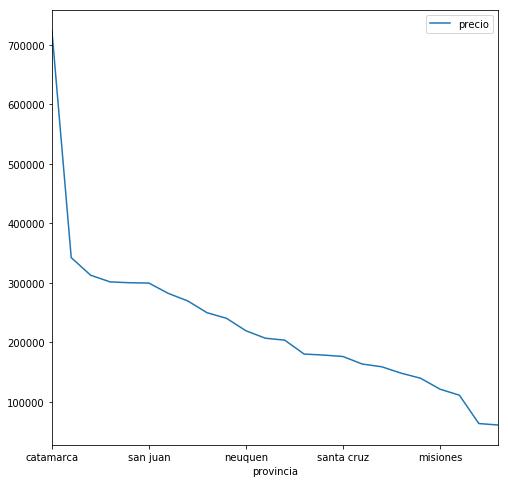

In [0]:
df.groupby('provincia').mean()[['precio']].sort_values(by='precio', ascending=False).plot()

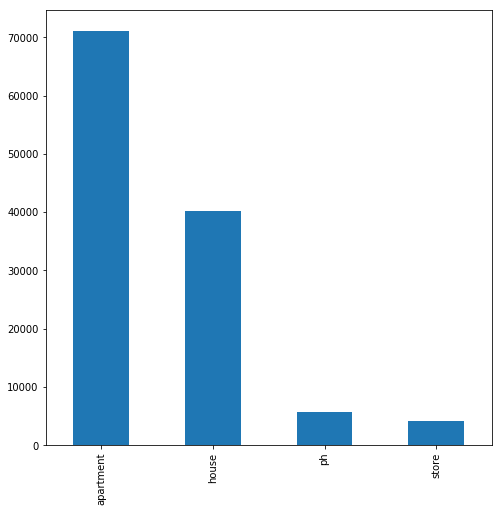

In [0]:
df['tipo'].value_counts().plot.bar()

In [0]:
df['provincia'].value_counts().head(10)

buenos aires       61131
capital federal    32316
cordoba            12069
santa fe           10172
rio negro            808
neuquen              733
mendoza              681
tucuman              674
corrientes           583
misiones             464
Name: provincia, dtype: int64

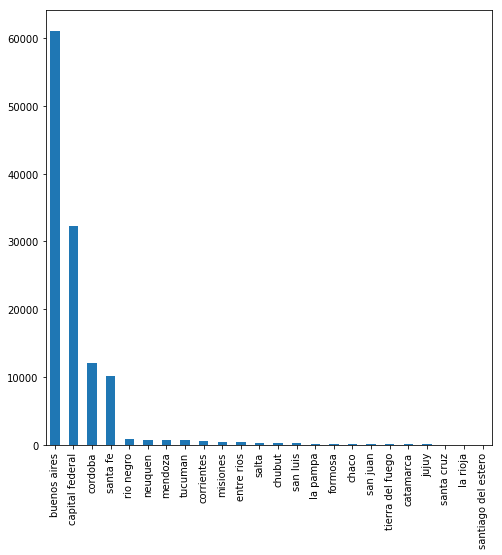

In [0]:
df['provincia'].value_counts().plot.bar()

In [0]:
df['zona'].describe()

count     116440
unique       567
top             
freq       76023
Name: zona, dtype: object

In [0]:
df['precio'].describe()

count    1.008100e+05
mean     2.397006e+05
std      3.913239e+05
min      0.000000e+00
25%      8.973388e+04
50%      1.450000e+05
75%      2.650000e+05
max      4.654544e+07
Name: precio, dtype: float64

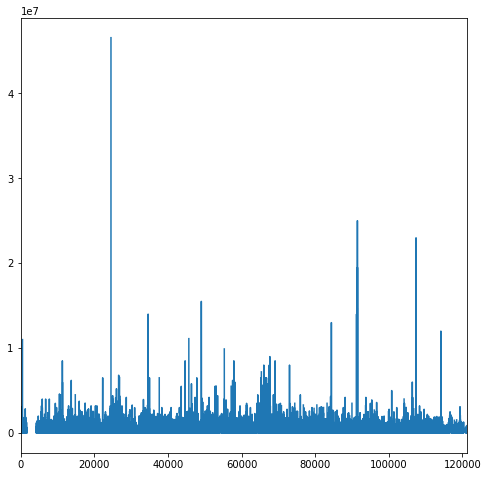

In [0]:
df['precio'].plot()

In [0]:
df['m2_total'].describe()

count    105906.000000
mean        212.958605
std        1677.960743
min           1.000000
25%          50.000000
50%          82.000000
75%         189.000000
max      200000.000000
Name: m2_total, dtype: float64

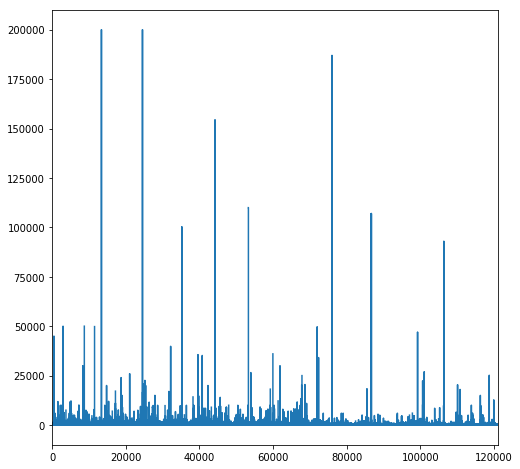

In [0]:
df['m2_total'].plot()

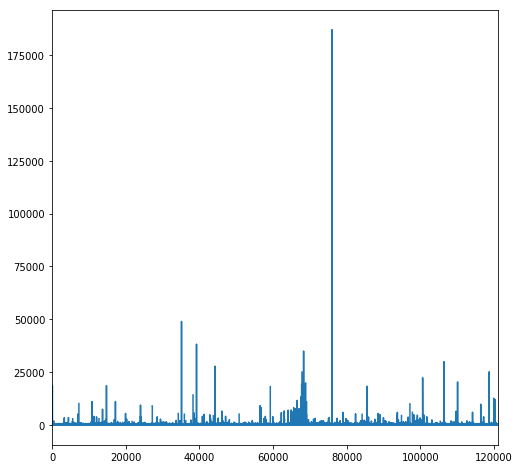

In [0]:
df['m2_cubierto'].plot()

# Notas en clase

- Datos por provincia
- Precio por barrio

-- bivariado?